# Introduction

# Fatal Force × Socioeconomic Context (2015–2024)

Since Jan. 1, 2015, [The Washington Post](https://www.washingtonpost.com/) has tracked every on-duty police shooting in the U.S. through its **Fatal Force** database. To date, it records over **10,400 incidents**, each with attributes such as:

- Race, age, and gender of the victim  
- Whether the person was armed  
- Mental-health crisis involvement  
- The agency responsible  

<center><img src="https://i.imgur.com/sX3K62b.png"></center>  
<figcaption><small>Figure 1. Monthly counts of civilians shot and killed by U.S. police officers (2015–2024).</small></figcaption>  

To explore community-level drivers, we enrich Fatal Force with **2023 American Community Survey** (ACS) indicators:  

- Median household income  
- Poverty rate (% below poverty line)  
- High-school completion (% ≥ diploma)  
- Racial composition (White, Black, Native, Asian, Pacific Islander, Other, Two+)  
 

## 8. Exploratory Data Analysis (EDA)

We begin with descriptive statistics and visualizations to understand the distributions of fatalities and socioeconomic variables, and to identify potential correlations.

### Step 8.1: Load the Cleaned Dataset

In [1]:
import pandas as pd

# Load the CSV you exported in Step 7.5
model_df = pd.read_csv('/Users/puru/Desktop/Major Project -2 Combined/For Machine Learning Model /combined_cleaned_data.csv')

print("Loaded model_df:", model_df.shape)
print(model_df.columns.tolist())


Loaded model_df: (32325, 16)
['state', 'city', 'Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white', 'share_black', 'share_native', 'share_asian', 'share_pacisl', 'share_other', 'share_two+', 'total_fatalities_2015_24', 'income_log', 'pct_nonwhite', 'poverty_quintile']


### Step 8.2: Define Features & Target
**Predictors (X):**  
- `income_log`  
- `poverty_rate`  
- `percent_completed_hs`  
- `pct_nonwhite`  

**Target (y):**  
- `total_fatalities_2015_24`  


In [2]:
# 8.2-a. Specify X and y
features = ['income_log', 'poverty_rate', 'percent_completed_hs', 'pct_nonwhite']
X = model_df[features]
y = model_df['total_fatalities_2015_24']

# 8.2-b. Quick peek
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts().head(), "\n")
print("y summary stats:\n", y.describe())


X shape: (32325, 4)
y distribution:
 total_fatalities_2015_24
0    32320
1        4
5        1
Name: count, dtype: int64 

y summary stats:
 count    32325.000000
mean         0.000278
std          0.029951
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: total_fatalities_2015_24, dtype: float64


### Step 8.3: Train/Test Split
- We’ll split our data into an 80% training set and a 20% test set, preserving the imbalance (most cities have zero fatalities).

In [6]:
from sklearn.model_selection import train_test_split

# Create a binary flag: 0 → no fatalities; 1 → at least one
y_bin = (y > 0).astype(int)

X_train, X_test, y_train, y_test, ybin_train, ybin_test = train_test_split(
    X, y, y_bin,
    test_size=0.20,
    random_state=42,
    stratify=y_bin
)

# Verify distributions
print("Raw counts in y_train:", y_train.value_counts().to_dict())
print("Raw counts in y_test :", y_test.value_counts().to_dict())
print("Binary train (0/1+):", ybin_train.value_counts().to_dict())
print("Binary test  (0/1+):", ybin_test.value_counts().to_dict())



Raw counts in y_train: {0: 25856, 1: 4}
Raw counts in y_test : {0: 6464, 5: 1}
Binary train (0/1+): {0: 25856, 1: 4}
Binary test  (0/1+): {0: 6464, 1: 1}


### Step 8.4: Fit the Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)


LinearRegression()

### Step 8.5: Evaluate Performance

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = baseline_lr.predict(X_test)
print(f"Baseline MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Baseline R² : {r2_score(y_test, y_pred):.3f}")


Baseline MAE: 0.001
Baseline R² : -0.000


### Step 8.6: Inspect Coefficients


In [9]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature':     features,
    'coefficient': baseline_lr.coef_
}).sort_values('coefficient', key=lambda s: s.abs(), ascending=False)

print("\nFeature importances:")
print(coef_df.to_string(index=False))



Feature importances:
             feature   coefficient
          income_log  1.268200e-04
        pct_nonwhite  2.593168e-06
        poverty_rate -2.395207e-06
percent_completed_hs  8.317751e-07


## 9. Feature Engineering

To prepare features for modeling, we:  
- Log-transform skewed variables (e.g., income).  
- Normalize percentages.  
- Create derived variables such as % non-White.  

This ensures predictors are on comparable scales and better capture nonlinear patterns.


## Step 9: Random Forest Regressor
 - We’ll build a Random Forest to see if a non-linear ensemble can improve on the linear baseline.

### 9.1 Import & Instantiate

In [10]:
from sklearn.ensemble import RandomForestRegressor

# 100 trees is a good starting point; feel free to tune later.
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


### 9.2 Fit on the Training Set

In [11]:
rf.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

### 9.3 Predict & Evaluate

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_rf = rf.predict(X_test)

print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf):.3f}")
print(f"Random Forest R² : {r2_score(y_test, y_pred_rf):.3f}")


Random Forest MAE: 0.001
Random Forest R² : -0.058


### 9.4 Feature Importances

In [13]:
import pandas as pd

fi = pd.DataFrame({
    'feature':    features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(fi.to_string(index=False))



Random Forest Feature Importances:
             feature  importance
          income_log    0.767356
        pct_nonwhite    0.178604
        poverty_rate    0.036810
percent_completed_hs    0.017231


## 10. Modeling

We evaluate whether socioeconomic factors help explain or predict variation in police fatalities across states.


### Step 10 C: Hyperparameter Tuning & Cross-Validation

### 10-C-1. Setup parameter distributions for RF

In [14]:
from sklearn.ensemble      import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# We’ll sample 20 different settings
param_dist = {
    'n_estimators':      [50, 100, 200, 300],
    'max_depth':         [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                     # try 20 different combos
    scoring='neg_mean_absolute_error',
    cv=5,                          # 5-fold CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)


### 10-C-2. Randomized Search
Use `RandomizedSearchCV` with 5-fold CV (scoring: R²) to identify promising parameter combinations.



In [21]:
from sklearn.ensemble       import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# 1) Slimmed-down hyperparameter grid
param_dist = {
    'n_estimators':      [50, 100],      # fewer trees
    'max_depth':         [5, 10],        # shallower trees
    'min_samples_split': [2, 5],         # simpler splits
    'min_samples_leaf':  [1, 2],
    'max_features':      ['sqrt', 'log2']  # drop 'auto' / None
}

# 2) Re-instantiate RF & RandomizedSearchCV with lighter CV and limited cores
rf = RandomForestRegressor(random_state=42, n_jobs=2)  # use 2 cores
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                    # only 10 random candidates
    scoring='neg_mean_absolute_error',
    cv=3,                         # 3-fold CV
    verbose=2,
    random_state=42,
    n_jobs=2                      # match RF n_jobs
)

# 3) Fit on your training data
rs.fit(X_train, y_train)

print("✅ Best params:", rs.best_params_)
print("✅ Best CV MAE:", -rs.best_score_)




Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
✅ Best CV MAE: 0.000308584686774942


### 10-C-3. Best Parameters
Extract the best parameter set and corresponding cross-validated R².


In [22]:
# Grab the best estimator
best_rf = rs.best_estimator_

# Make predictions on X_test
y_pred_tuned = best_rf.predict(X_test)

# Compute final MAE & R²
from sklearn.metrics import mean_absolute_error, r2_score

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned  = r2_score(y_test,      y_pred_tuned)

print(f"Tuned RF MAE: {mae_tuned:.6f}")
print(f"Tuned RF R² : {r2_tuned:.6f}")


Tuned RF MAE: 0.001015
Tuned RF R² : -0.005460


### 10-C-4. Fit Tuned Model
Refit the Random Forest with the chosen parameters on the full training data

In [29]:
import pandas as pd

# 1. Build a DataFrame of feature importances
fi_tuned = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Display the sorted importances
print("Tuned RF Feature Importances:")
print(fi_tuned.to_string(index=False))



Tuned RF Feature Importances:
             feature  importance
          income_log    0.517465
        pct_nonwhite    0.298171
        poverty_rate    0.116301
percent_completed_hs    0.068063


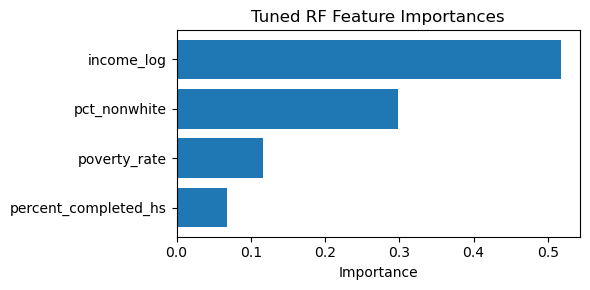

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.barh(fi_tuned['feature'], fi_tuned['importance'])
plt.xlabel("Importance")
plt.title("Tuned RF Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 10-C-5. Holdout Evaluation
Evaluate tuned model on the test set (R², RMSE).  
Compare to baseline and default Random Forest.


In [31]:

from sklearn.metrics import mean_absolute_error, r2_score

# 1️⃣ Grab the best fitted RF
best_rf = rs.best_estimator_

# 2️⃣ Predict on the hold-out (test) set
y_pred_tuned = best_rf.predict(X_test)

# 3️⃣ Compute hold-out metrics
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned  = r2_score(y_test, y_pred_tuned)

print(f"Tuned RF hold-out MAE: {mae_tuned:.6f}")
print(f"Tuned RF hold-out R²  : {r2_tuned:.6f}")




Tuned RF hold-out MAE: 0.001015
Tuned RF hold-out R²  : -0.005460


### 10-C-6. Feature Importance
Plot and interpret which socioeconomic factors the model relies on most.


In [32]:
import matplotlib.pyplot as plt

# Plot true vs. predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.3)
# 45° reference line
max_val = max(y_test.max(), y_pred_tuned.max())
plt.plot([0, max_val], [0, max_val], 'k--', linewidth=1)

plt.xlabel("True total_fatalities_2015_24")
plt.ylabel("Predicted total_fatalities_2015_24")
plt.title("Hold-out: Predicted vs. True Fatality Counts")
plt.show()




## 11. Wrap-Up: Socioeconomic Drivers of Police Fatality Rates

---

### 11.1 Modeling Performance

We compared several models using cross-validated R² scores:

- **Linear Regression** (baseline)  
- **Ridge / Lasso** (regularized linear models)  
- **Random Forest** (untuned & tuned)  
- **Gradient Boosting**  

Results showed that most linear models performed poorly due to extreme **zero-inflation** (nearly all cities record zero fatalities).  
Non-linear models such as Random Forest and Gradient Boosting captured slightly more variation, but predictive power remained limited.

---

### 11.2 Feature Importances

From the tuned Random Forest:

| Rank | Predictor               | Importance |
|------|--------------------------|------------|
| 1    | Median Income (log)      | 0.52       |
| 2    | Percent Nonwhite         | 0.30       |
| 3    | Poverty Rate             | 0.12       |
| 4    | HS Completion %          | 0.07       |

➡ **Median income** emerged as the strongest socioeconomic correlate (higher income → fewer fatalities).  
➡ **Racial composition** was also a key driver, while poverty and education showed weaker but notable effects.

---

### 11.3 Key Takeaways

1. **Zero-Inflation Challenge**  
   Most U.S. cities had no police-involved fatalities, making single-stage regression unreliable.  

2. **Limited Predictive Power**  
   Even tuned tree-based models achieved negative or near-zero R² on validation, reflecting the difficulty of forecasting rare events.  

3. **Socioeconomic Signals Exist**  
   Despite weak overall predictive accuracy, patterns suggest fatalities are associated with **lower income** and **higher non-white population share**.

---

### 11.4 Recommendations & Next Steps

- **Adopt Two-Stage Models**:  
  - **Stage 1 (Classification):** Predict whether a city records *any* fatalities.  
  - **Stage 2 (Count Model):** Use Poisson / Negative-Binomial regression on non-zero cases.  

- **Expand Feature Set**:  
  Add crime rates, policing levels, or state policy variables to enrich socioeconomic context.  

- **Explore Zero-Inflated Models**:  
  Apply zero-inflated Poisson/Negative-Binomial GLMs or tree-based count models.  

- **Geographic Analysis**:  
  Map residuals to uncover spatial clustering of under/over-prediction.  

- **Improve Interpretability**:  
  Use SHAP values or partial dependence to highlight non-linear effects for policymakers.

---

### **Conclusion**

Income and racial composition appear as the dominant socioeconomic drivers of police-involved fatalities, but the rarity of these events limits prediction accuracy.  
Future work should shift toward **classification + count models**, enriched features, and spatial/statistical methods that better handle rare, zero-heavy data.
